In [177]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
from census import Census
from us import states

from matplotlib import pyplot as plt
import seaborn as sns

In [146]:
raw_data_dir = "data/raw"

raw_acs_population_path = os.path.join(raw_data_dir, "ACSDT5Y2023.B01003_2025-10-09T231035", "ACSDT5Y2023.B01003-Data.csv")
raw_incidents_path = os.path.join(raw_data_dir, "Crime_Data_from_2020_to_Present.csv")

## Crime Incidents Data

In [147]:
# Read raw data
incidents_raw = pd.read_csv(raw_incidents_path)

In [148]:
# Columns in raw data
incidents_raw.columns

Index(['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME',
       'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes',
       'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc',
       'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1',
       'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT',
       'LON'],
      dtype='object')

In [149]:
# Filter out invalid lat/lon values -- online it says locations errors or missings are encoded as 0, 0 for lat/lon
incidents = incidents_raw[~((incidents_raw['LAT'] == 0) & (incidents_raw['LON'] == 0))]

In [150]:
# Convert to GeoDataFrame
incidents_geo = gpd.GeoDataFrame(
    incidents,
    geometry=gpd.points_from_xy(incidents["LON"], incidents["LAT"]),
    crs="EPSG:4326"
)

## ZCTA Boundary Data

In [151]:
# Load ZCTA data from Census
# -- Using 2023 because this is the most recent census data year and they should match
zctas = gpd.read_file(
    "https://www2.census.gov/geo/tiger/TIGER2023/ZCTA520/tl_2023_us_zcta520.zip"
)
zctas = zctas.to_crs("EPSG:4326")
zctas = zctas.rename(columns={"ZCTA5CE20": "ZCTA"})
print(f"Loaded {len(zctas)} ZIP code areas in the US")

Loaded 33791 ZIP code areas in the US


## Join ZCTA Boundary Data to Crime Incidents based on Latitude/Longitude

In [152]:
# Spatial join to merge ZCTA code if the lat/lon point is within the ZCTA boundary
# -- Not exactly sure how polygons/shape files work tbh, but have done a similar process to load in ACS data at work
incidents_geo = incidents_geo.to_crs(zctas.crs)
incidents_zcta = gpd.sjoin(incidents_geo, zctas, how = "left", predicate = "within")

In [153]:
# Drop crimes that we can't map to a zip code
incidents_zcta = incidents_zcta[~incidents_zcta["ZCTA"].isnull()]

## Crime Incidents Data Prep

In [154]:
# Create violent/non-violent classification
# -- Taken from Vikram's code

# Make a list of crimes that we identified as Violent from one of the previous steps

violent_crimes = ['CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT', 'INTIMATE PARTNER - SIMPLE ASSAULT', 'ROBBERY', 'CRIMINAL HOMICIDE', 'ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT', 'RAPE, FORCIBLE', 'MANSLAUGHTER, NEGLIGENT', 'BATTERY - SIMPLE ASSAULT', 'LYNCHING']

# Create a new Crime Type column with Violent and Non-Violent labels
incidents_zcta['Crime Type'] = np.where(incidents_zcta['Weapon Used Cd'].notnull() | incidents_zcta['Crm Cd Desc'].isin(violent_crimes), 'Violent', 'Non-Violent')

In [155]:
# Aggregate to the zip code level and desired time period
# -- For now, doing monthly

# Convert incident date to pandas datetime
incidents_zcta["incident_date"] = pd.to_datetime(incidents_zcta['DATE OCC'], format = "%m/%d/%Y %I:%M:%S %p")

# Get month/year from date
incidents_zcta["incident_month"] = incidents_zcta['incident_date'].dt.to_period('M')

In [156]:
##############################
# SUMMARIES OF ZIP CODE/AREA 
##############################
zips_per_area = incidents_zcta.groupby("AREA")["ZCTA"].nunique().reset_index()
zips_per_area = zips_per_area.rename(columns = {"ZCTA": "n_zips"})
print("ZIP codes per area:", min(zips_per_area["n_zips"]), "to", max(zips_per_area["n_zips"]))

areas_per_zip = incidents_zcta.groupby("ZCTA")["AREA"].nunique().reset_index()
areas_per_zip = areas_per_zip.rename(columns = {"AREA": "n_areas"})
print(len(areas_per_zip), "zip codes in LAPD data")

overlapping_zips = areas_per_zip[areas_per_zip["n_areas"] > 1]
print("Overlapping ZIP codes (in multiple areas):", len(overlapping_zips))

areas_with_overlaps = incidents_zcta[incidents_zcta["ZCTA"].isin(overlapping_zips["ZCTA"])]["AREA"].unique()
print("Areas with overlapping zip codes:", len(areas_with_overlaps))

ZIP codes per area: 9 to 25
150 zip codes in LAPD data
Overlapping ZIP codes (in multiple areas): 75
Areas with overlapping zip codes: 21


In [157]:
# Aggregate incident data to zip code and month
incidents_zcta_month = incidents_zcta.groupby(["ZCTA", "incident_month"])["Crime Type"].value_counts().unstack(fill_value = 0).add_prefix("crime_").reset_index()


#### THINGS TO FIGURE OUT
# -- Rolling window calculations
# -- Need to fill in months if they're missing for a zip code first?
#incidents_zcta_month['violent_rolling_sum_2M'] = incidents_zcta_month['crime_Violent'].rolling(window='2M', on="incident_month").sum()

In [158]:
# Fill in missing months in the data
# -- There may be certain months that a zip code didn't have any crime, so there isn't a row
# -- We need a row for every zip/month combo, and we can fill crime counts with 0s

# Create date formatted column
incidents_zcta_month["incident_month_timestamp"] = incidents_zcta_month['incident_month'].dt.to_timestamp()

# List of all ZCTAs
incidents_zctas = incidents_zcta_month['ZCTA'].unique()

# List of all months between min and max month in data
all_months = pd.date_range(incidents_zcta_month["incident_month_timestamp"].min(), incidents_zcta_month["incident_month_timestamp"].max(), freq = "MS")

# Get all combinations of ZCTAs and months
all_zctas_months = pd.MultiIndex.from_product([incidents_zctas, all_months], names = ["ZCTA", "incident_month_timestamp"])

# Reindex your dataframe
incidents_zcta_month_fill = incidents_zcta_month.set_index(["ZCTA", "incident_month_timestamp"]).reindex(full_index).reset_index()

# Clean up df
incidents_zcta_month_fill = incidents_zcta_month_fill.drop(["incident_month"], axis = 1)
incidents_zcta_month_fill = incidents_zcta_month_fill.fillna(0)

In [159]:
# Calculate lagging indicators
incidents_zcta_month_fill["violent_lag_1"] = incidents_zcta_month_fill.groupby("ZCTA")["crime_Violent"].shift(1)
incidents_zcta_month_fill["violent_lag_2"] = incidents_zcta_month_fill.groupby("ZCTA")["crime_Violent"].shift(2)
incidents_zcta_month_fill["violent_lag_3"] = incidents_zcta_month_fill.groupby("ZCTA")["crime_Violent"].shift(3)

incidents_zcta_month_fill

## ADD SEASONALITY FIELDS? IF MONTH LEVEL, THEN SEASON? crime usually higher in summer, lower in winter

Crime Type,ZCTA,incident_month_timestamp,crime_Non-Violent,crime_Violent,violent_lag_1,violent_lag_2,violent_lag_3
0,90001,2020-01-01,48.0,38.0,NaN,NaN,NaN
1,90001,2020-02-01,34.0,12.0,38.0,NaN,NaN
2,90001,2020-03-01,30.0,16.0,12.0,38.0,NaN
3,90001,2020-04-01,16.0,25.0,16.0,12.0,38.0
4,90001,2020-05-01,31.0,22.0,25.0,16.0,12.0
...,...,...,...,...,...,...,...
9745,91801,2025-01-01,0.0,0.0,0.0,0.0,0.0
9746,91801,2025-02-01,0.0,0.0,0.0,0.0,0.0
9747,91801,2025-03-01,0.0,0.0,0.0,0.0,0.0
9748,91801,2025-04-01,0.0,0.0,0.0,0.0,0.0


## ACS Data

In [160]:
# Read in ACS data
acs_population_raw = pd.read_csv(raw_acs_population_path)
acs_population_raw.head()

###### GET MORE ACS FIELDS
# -- Median income
# -- poverty related fields?
# -- unemployment
# -- income inequality index 
# Not sure if these are available at zip level

,GEO_ID,NAME,B01003_001E,B01003_001M,Unnamed: 4
0,Geography,Geographic Area Name,Estimate!!Total,Margin of Error!!Total,NaN
1,0400000US06,California,39242785,*****,NaN
2,860Z200US89010,ZCTA5 89010,355,127,NaN
3,860Z200US89019,ZCTA5 89019,2355,489,NaN
4,860Z200US89060,ZCTA5 89060,12783,1225,NaN


In [161]:
# Drop first two rows
acs_population = acs_population_raw.drop(index = range(0, 2)).reset_index(drop = True)

# Drop last column
acs_population = acs_population.drop(acs_population.columns[-1], axis = 1)

# Reset column  names
acs_pop_colnames = ["geo_id", "zcta_name", "total_population", "total_population_moe"]
acs_population.columns = acs_pop_colnames

# Get zip code on it's own (keep as string to match with zcta table above)
acs_population["ZCTA"] = acs_population["zcta_name"].str.split(' ', n = 1).str[1]

# Convert population columns to numeric
acs_population["total_population"] = pd.to_numeric(acs_population["total_population"], errors = "coerce")
acs_population["total_population_moe"] = pd.to_numeric(acs_population["total_population_moe"], errors = "coerce")

# Only keep necessary columns that we want to join
# -- Not sure if we need to use margin of error?? Read into this from ACS on how/if it should be used
acs_population = acs_population[["ZCTA", "total_population", "total_population_moe"]]

acs_population.head()

,ZCTA,total_population,total_population_moe
0,89010,355,127
1,89019,2355,489
2,89060,12783,1225
3,89061,7835,967
4,89439,2071,337


## Merge ACS Data to Incidents

In [162]:
incidents_final = pd.merge(incidents_zcta_month_fill, acs_population, on = "ZCTA", how = "left")

In [168]:
# Clean up
# -- Drop rows with NAs for lagging indicators (only happens January - March 2020)
# ---- We want a month to have a full prior 3 months of data (not useful to have null for any of our features)
incidents_final = incidents_final[~incidents_final.isnull().any(axis=1)]

# -- Drop data March 2024 or after because of change in reporting
incidents_final = incidents_final[incidents_final["incident_month_timestamp"] < "2024-03-01"]

count                             7050
mean     2022-03-02 01:31:54.893617152
min                2020-04-01 00:00:00
25%                2021-03-01 00:00:00
50%                2022-03-01 00:00:00
75%                2023-03-01 00:00:00
max                2024-02-01 00:00:00
Name: incident_month_timestamp, dtype: object

In [169]:
# Train/validation/test split (60/20/20)
# -- Do this by dates instead of randomly
timeline = incidents_final['incident_month_timestamp'].sort_values().unique()
n_periods = len(timeline)

# -- Determine train/val/test cutoffs
train_cutoff_idx = int(0.6 * n_periods)
val_cutoff_idx = int(0.8 * n_periods)

train_end_date = timeline[train_cutoff_idx - 1]
val_end_date = timeline[val_cutoff_idx - 1]

incidents_train = incidents_final[incidents_final['incident_month_timestamp'] <= train_end_date]
incidents_val = incidents_final[(incidents_final['incident_month_timestamp'] > train_end_date) & (incidents_final['incident_month_timestamp'] <= val_end_date)]
incidents_test = incidents_final[incidents_final['incident_month_timestamp'] > val_end_date]

####### NEED TO LOOK INTO THAT ZERO POPULATION ONE... 

In [164]:
incidents_train.to_csv('data/processed/train.csv')
incidents_val.to_csv('data/processed/validation.csv')
incidents_test.to_csv('data/processed/test.csv')

# EDA

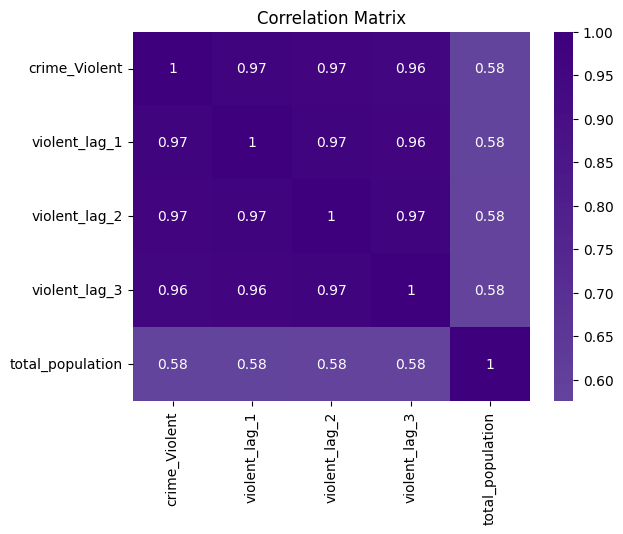

In [178]:
# Correlation
cm = incidents_train[["crime_Violent", "violent_lag_1", "violent_lag_2", "violent_lag_3", "total_population"]].corr()

hm = sns.heatmap(
    cm.values,
    yticklabels=cm.index,
    xticklabels=cm.columns,
    cmap = "Purples",
    center = 0,
    annot = True
)
plt.title("Correlation Matrix")
plt.show()